In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import asymNdimPdf as apdf

In [2]:
import matplotlib as mpl
mpl.rcParams['legend.frameon']  = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize']  = 18
mpl.rcParams['axes.labelsize']  = 18
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['figure.figsize']  = (10, 7)

In [3]:
cov = np.array([
    [ 1.0000, -0.1949,  0.2583, -0.3933],
    [-0.1949,  1.0000, -0.1188,  0.2919],
    [ 0.2583, -0.1188,  1.0000, -0.3443],
    [-0.3933,  0.2919, -0.3443,  1.0000],
])

In [4]:
measList = np.array([
    [294288603.77097332, 29726222.606283784, -23672504.108643234],
    [1422822752.7824574, 34181144.593426704, -33513316.302916765],
    [1267256904.8604925, 34413027.555306196, -32740743.069167614],
    [189913774.63168541, 17348726.511133254, -19868612.427323759],
])
measList = np.abs(measList) * 1e-6

print(measList)

[[ 294.28860377   29.72622261   23.67250411]
 [1422.82275278   34.18114459   33.5133163 ]
 [1267.25690486   34.41302756   32.74074307]
 [ 189.91377463   17.34872651   19.86861243]]


In [5]:
snParams = []
for m in measList:
    snParams.append(apdf.paramFromMeas(m[0], m[2], m[1]))               

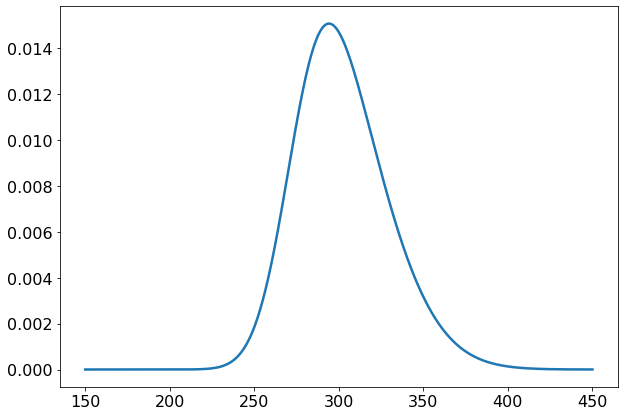

In [6]:
# Example of 1D PDF for the 1st bin
x = np.linspace(150, 450, 1000)
l, s, a = snParams[0]
plt.plot(x, apdf.ndimSkewNormal(loc=l, scale=s, alpha=a).pdf(x));

In [7]:
# N-dim PDF
loc, scale, alpha = [], [], []
for p in snParams:
    loc.append(p[0])
    scale.append(p[1])
    alpha.append(p[2])

ndSN = apdf.ndimSkewNormal(loc=loc, scale=scale, cov=cov, alpha=alpha)
ndSNnoCorr = apdf.ndimSkewNormal(loc=loc, scale=scale, cov=np.diag((1, 1, 1, 1)), alpha=alpha)

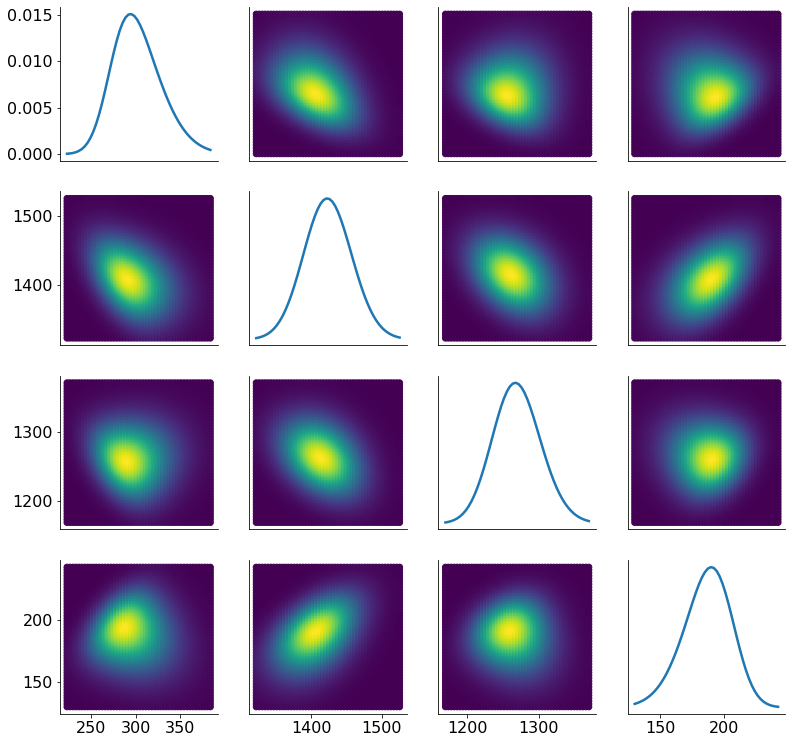

In [8]:
ndSN.plot(contour=False)

In [18]:
dLog, wLog = ndSN.generateDataLog(n=9000000, borders=ndSN.borders(15))
w = np.array([-0.75, -0.25, 0.25, 0.75])
Ckk = -9 * np.sum(dLog*w, axis=1) / np.sum(dLog, axis=1)

In [19]:
def fitWeightedDistribution(data, weights, nbins=100):

    from scipy import optimize
    
    # Weighted histogram
    Nbins    = nbins
    bins     = np.linspace(data.min(), data.max(), Nbins)
    ydata, _ = np.histogram(data, weights=weights, bins=bins, density=True)

    # Bin center as x data
    xdata = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

    # Loss function
    def loss(x):
        l, s, a = x
        f = apdf.ndimSkewNormal(loc=l, scale=s, alpha=a).pdf
        w = np.sqrt(np.abs(xdata - xdata.mean()))
        w = w/w.max()
        dy2 = (ydata - f(xdata))**2
        return np.sum(dy2*w)

    l0 = np.average(data, weights=weights) 
    s0 = np.sqrt( np.average((data-l0)**2, weights=weights) )
    a0 = 1.

    res = optimize.minimize(loss, tol=1e-6, x0=[l0, s0, a0], method='Nelder-Mead')
    loc, scale, alpha = res.x
    
    return loc, scale, alpha

In [20]:
loc, scale, alpha = fitWeightedDistribution(Ckk, weights=wLog, nbins=100)

1.0657818919249942 0.27401784269519375 0.10179691627820235
(0.3266030474288691, 0.07959428477356341, 0.08405573899046342)


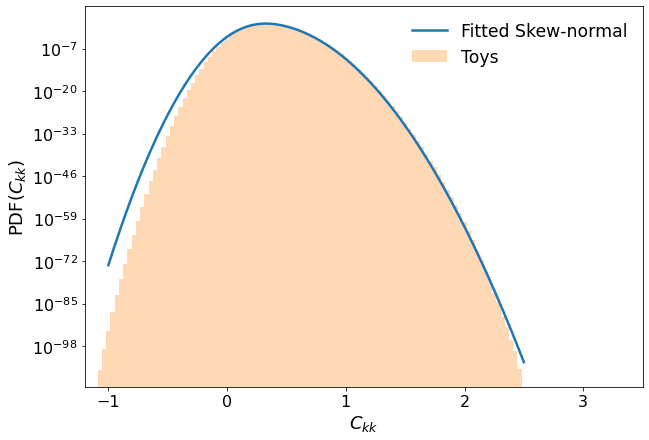

In [26]:
print(alpha, loc, scale)
sn = apdf.ndimSkewNormal(loc=loc, scale=scale, alpha=alpha)
x = np.linspace(-1, 2.5, 1000)
plt.plot(x, sn.pdf(x), label='Fitted Skew-normal')
plt.hist(Ckk, bins=100, weights=wLog, density=True, alpha=0.3, log=True, label='Toys')
plt.legend()
plt.xlabel('$C_{kk}$')
plt.ylabel('PDF($C_{kk}$)')
plt.xlim(-1.2, 3.5)
print(sn.measAsymError())

In [61]:
toys = apdf.generateData(ndSNnoCorr.pdf, n=9000000, xLim=[[150, 400], [1300, 1500], [1100, 1400], [100, 250]])

TypeError: generateData() got an unexpected keyword argument 'xLim'

(0.32131684705118235, 0.08067275189980683, 0.08691924175036844)


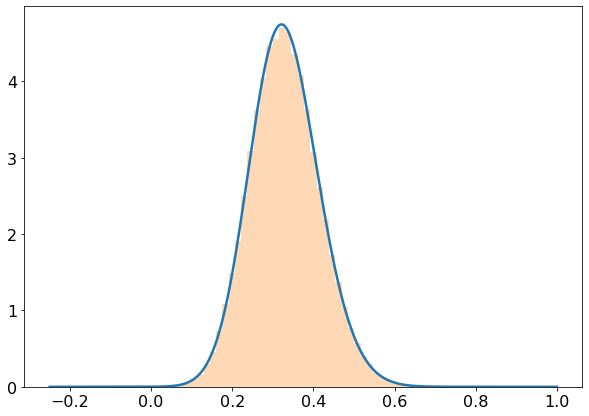

In [16]:
w = np.array([-0.75, -0.25, 0.25, 0.75])
Ckk = -9 * np.sum(toys*w, axis=1) / np.sum(toys, axis=1)
alpha, loc, scale = skewnorm.fit(Ckk)
sn = apdf.ndimSkewNormal(loc=loc, scale=scale, alpha=alpha)
x=np.linspace(-0.25, 1.0, 1000)
plt.plot(x, sn.pdf(x))
plt.hist(Ckk, bins=50, density=True, alpha=0.3);
print(sn.measAsymError())